In [98]:
# Install necessary library
!pip install segmentation_models --quiet
!pip install -U tensorflow keras segmentation-models --quiet

In [99]:
# List existing image files (zipped)
!ls

cpu  landcoverai  landcoverai-20250306T133829Z-001.zip	models


In [100]:
pwd

'/project'

In [101]:
# Necessary because of a bug https://github.com/qubvel/segmentation_models/issues/374
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [102]:
!pip install matplotlib scikit-learn --quiet

In [103]:
import os
import random
from pathlib import Path

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models as sm
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [104]:
# In case the model gets very slow, may be due to a bug in TF2.0. Uncomment this.
# https://github.com/tensorflow/tensorflow/issues/33024
# tf.compat.v1.disable_eager_execution()

# Also check this in case you notice training to be getting increasingly slow each epoch.
# https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch

In [105]:
# Define needed directory paths
dir_root = Path("/project/landcoverai/")
dir_train_img = Path(dir_root, "train_images/train/")
dir_train_mask = Path(dir_root, "train_masks/train/")
dir_val_img = Path(dir_root, "val_images/val/")
dir_val_mask = Path(dir_root, "val_masks/val/")
dir_models = Path("/project/models/")




# Show how many image files exist
for dir in [dir_train_img, dir_train_mask, dir_val_img, dir_val_mask]:
    files = patch_files = [file for file in dir.iterdir()]
    print(f"{dir} has {len(files)} images.")

/project/landcoverai/train_images/train has 2250 images.
/project/landcoverai/train_masks/train has 2250 images.
/project/landcoverai/val_images/val has 750 images.
/project/landcoverai/val_masks/val has 750 images.


In [106]:
classes = {
    0: "Not classified",
    1: "Building",
    2: "Woodland",
    3: "Water",
    4: "Roads",
}

### Visualize random patch alongside its mask

In [107]:
def plot_image_and_mask(image: Path):
    """
    Function to plot an image alongside its mask.
    """
    img = cv2.imread(image.as_posix())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_path = Path(image.as_posix().replace("/train_images/", "/train_masks/"))
    mask = cv2.imread(mask_path.as_posix())

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img)
    ax1.set_title("Channel 0")

    norm = mpl.colors.Normalize(vmin=0, vmax=4)
    cmap = plt.get_cmap("viridis")

    ax2.imshow(mask[:, :, 1], cmap=cmap, norm=norm)
    ax2.set_title("Mask")

    plt.show()


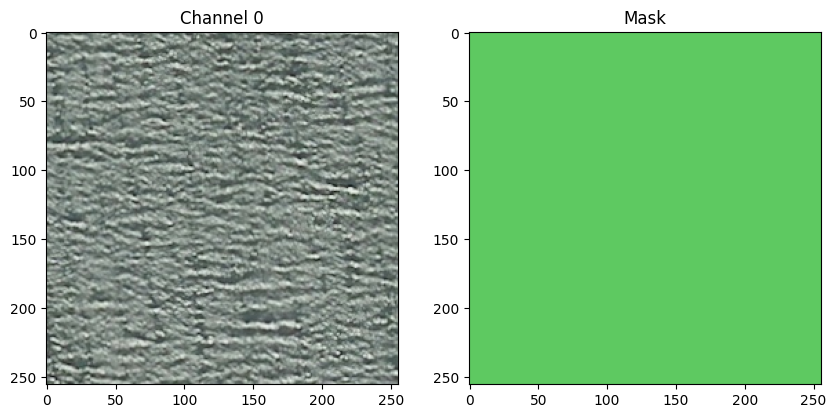

In [108]:
# Get paths of all images
img_files = [file for file in dir_train_img.iterdir()]

# Get random image from all images
img_path = np.random.choice(img_files)

plot_image_and_mask(img_path)


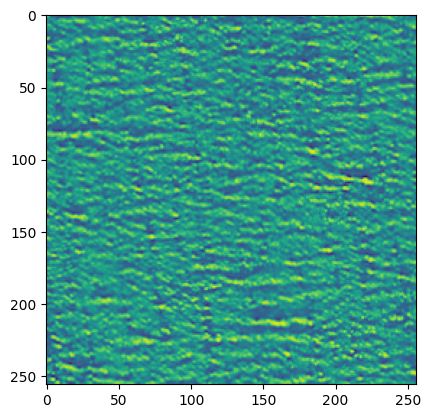

In [109]:
#Quick understanding of the dataset
temp_img = cv2.imread(img_path) #3 channels / spectral bands
plt.imshow(temp_img[:,:,0]) #View each channel...
plt.imshow(temp_img[:,:,1]) #View each channel...
plt.imshow(temp_img[:,:,2]) #View each channel...
temp_mask = cv2.imread(img_path) #3 channels but all same.






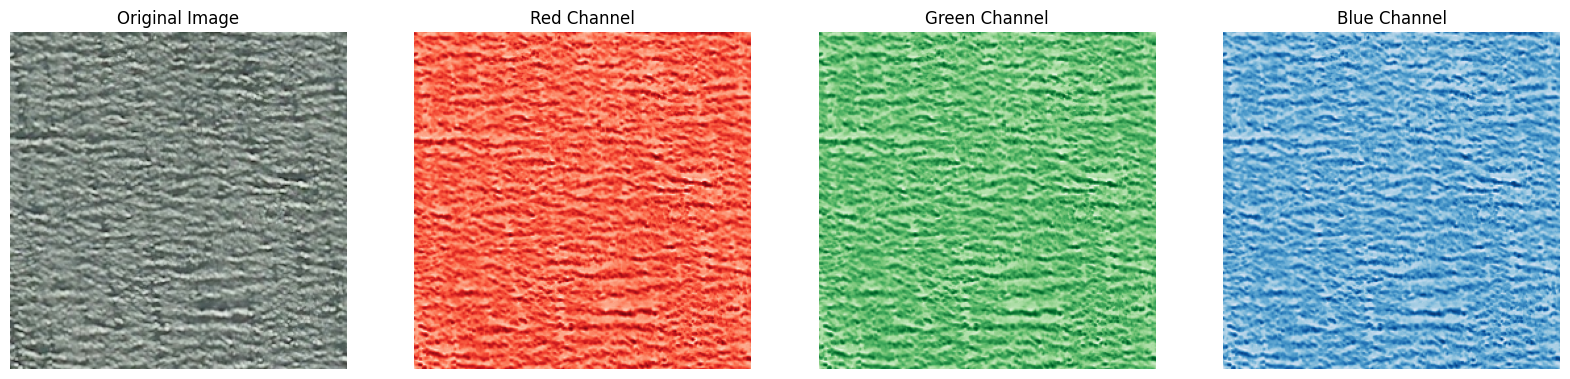

In [110]:


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread(img_path)  # Reads in BGR format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Split the channels
red_channel = img[:, :, 0]  # Red channel
green_channel = img[:, :, 1]  # Green channel
blue_channel = img[:, :, 2]  # Blue channel

# Plot the channels
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(img)  # Original image
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(red_channel, cmap="Reds")
axs[1].set_title("Red Channel")
axs[1].axis("off")

axs[2].imshow(green_channel, cmap="Greens")
axs[2].set_title("Green Channel")
axs[2].axis("off")

axs[3].imshow(blue_channel, cmap="Blues")
axs[3].set_title("Blue Channel")
axs[3].axis("off")

plt.show()

In [111]:
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [ 10  12  13  16  17  18  19  20  21  22  25  26  27  28  29  30  31  32
  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 233 234 238]  and the counts are:  [  1   1   1   1   1   1   1   3   2   1   2   1   2   2   3   1   4   

In [112]:
import numpy as np

# Example: Assume temp_mask[:,:,0] contains many unique labels
labels, count = np.unique(temp_mask[:, :, 0], return_counts=True)
print("Original Labels:", labels)

# Create a mapping dictionary to reassign labels to [0,1,2,3,...]
# Ensure all labels in temp_mask are included in the mapping
label_mapping = {old_label: new_label for new_label, old_label in enumerate(labels)} #Changed labels[:4] to labels

# Apply mapping to mask
remapped_mask = np.vectorize(label_mapping.get)(temp_mask[:, :, 0])

# Print new unique labels
new_labels, new_count = np.unique(remapped_mask, return_counts=True)
print("New Labels:", new_labels)
print("New Counts:", new_count)

Original Labels: [ 10  12  13  16  17  18  19  20  21  22  25  26  27  28  29  30  31  32
  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 233 234 238]
New Labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18

### Define Generator for images and masks

In [113]:

import segmentation_models as sm

seed = 24
batch_size = 16  # Lower to 8 in case of memory issues
n_classes = len(classes)
encoder_freeze = True

# Use this to preprocess input for transfer learning
BACKBONE = "resnet152"
preprocess_input = sm.get_preprocessing(BACKBONE) # Now sm is defined and this line should work.

In [114]:
print(n_classes)

5


In [115]:
def preprocess_data(img, mask, num_class):
    """
    Function to perform additional preprocessing after datagen.
    """
    scaler = MinMaxScaler()

    # Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

    # Preprocess based on the pretrained backbone
    img = preprocess_input(img)

    # Convert mask to one-hot
    mask = to_categorical(mask, num_class)

    return (img, mask)


In [116]:


def trainGenerator(train_img_path, train_mask_path, num_class):
    """
    Function to define the generator.
    We are not doing any zoom to make sure mask values are not interpolated.
    It is important to keep pixel values in mask as 0, 1, 2, 3, ...
    """
    img_data_gen_args = dict(
        horizontal_flip=True, vertical_flip=True, fill_mode="reflect"
    )

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        str(train_img_path),
        class_mode=None,
        batch_size=batch_size,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_directory(
        str(train_mask_path),
        class_mode=None,
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
    )

    train_generator = zip(image_generator, mask_generator)

    for img, mask in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [117]:
train_img_gen = trainGenerator(dir_train_img.parent, dir_train_mask.parent, num_class=n_classes)
val_img_gen = trainGenerator(dir_val_img.parent, dir_val_mask.parent, num_class=n_classes)

In [118]:
print(train_img_gen)
print(val_img_gen)

<generator object trainGenerator at 0x768bcca9b6e0>
<generator object trainGenerator at 0x768bcca9b220>


### Visualize some images to check

Make sure the generator is working and that images and masks are indeed lined up.

Found 2250 images belonging to 1 classes.
Found 2250 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


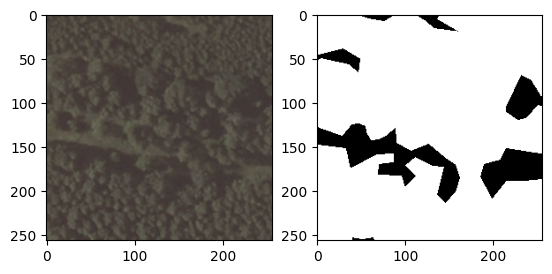

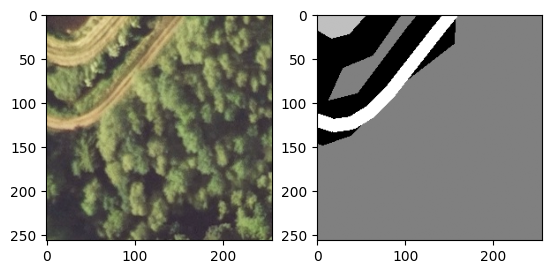

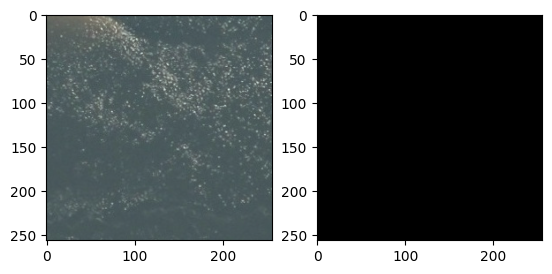

In [119]:
# Load the next batch of batch_size images
x, y = train_img_gen.__next__()

print(x.shape, y.shape)

# Make sure x has 3 layers (RGB)
assert x.shape[3] == 3

# Make sure y has n_classes layers
assert y.shape[3] == n_classes

for i in range(0, 3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()

Found 750 images belonging to 1 classes.
Found 750 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


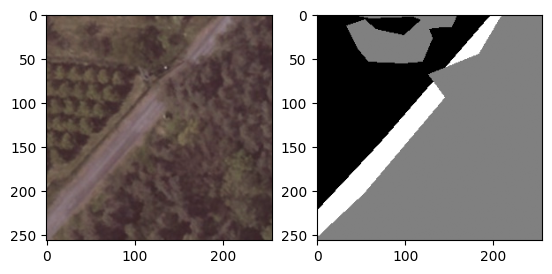

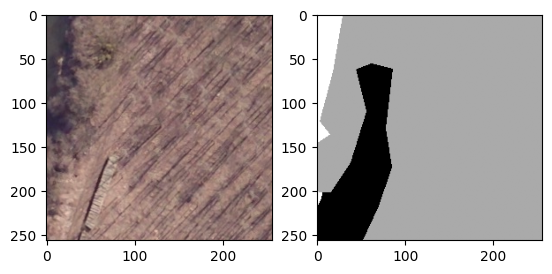

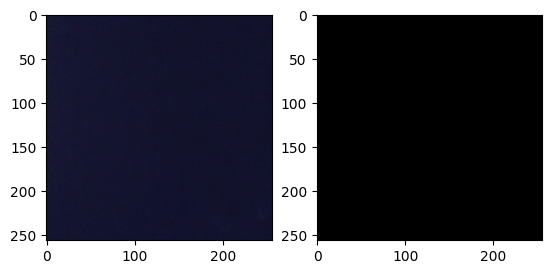

In [120]:
x_val, y_val = val_img_gen.__next__()

print(x_val.shape, y_val.shape)

# Make sure x has 3 layers (RGB)
assert x_val.shape[3] == 3

# Make sure y has n_classes layers
assert y_val.shape[3] == n_classes

for i in range(0, 3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()


### Define the model metrics and load model

In [121]:
num_train_imgs = len([file for file in dir_train_img.iterdir() if file.is_file()])
num_val_images = len([file for file in dir_val_img.iterdir() if file.is_file()])

steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_images // batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH = x.shape[2]
IMG_CHANNELS = x.shape[3]

EPOCHS = 50

In [122]:
print(num_train_imgs)
print(num_val_images)
print(steps_per_epoch)
print(val_steps_per_epoch)

2250
750
140
46


### Use transfer learning using pretrained encoder in the U-Net

We use ***Intersection over Union (IoU)*** as evaluation metric (see [here](https://towardsdatascience.com/iou-a-better-detection-evaluation-metric-45a511185be1)). is used when calculating Mean average precision (mAP). It is a number from 0 to 1 that specifies the amount of overlap between the predicted and ground truth bounding box:

- an IoU of 0 means that there is no overlap between the boxes
- an IoU of 1 means that the union of the boxes is the same as their overlap indicating that they are completely overlapping

In [123]:
# Define the model
model = sm.Unet(
    BACKBONE,
    encoder_weights="imagenet",
    encoder_freeze=encoder_freeze,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    classes=len(classes),
    activation="softmax",
)
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import tensorflow as  tf


def custom_iou_score(gt, pr, **kwargs):


    # Cast to float32 using Keras backend
    gt = tf.keras.backend.cast(gt, dtype='float32')
    pr = tf.keras.backend.cast(pr, dtype='float32')
    return sm.metrics.iou_score(gt, pr, **kwargs)


model.compile(
    "Adam",
    loss=sm.losses.categorical_focal_jaccard_loss,
    metrics=[custom_iou_score],
)

# Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

print(model.summary())
print(model.input_shape)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_156  │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_157  │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_158  │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_1… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, 64, 64,    │          0 │ stage1_unit1_bn3

 Total params: 67,295,774 (256.71 MB)

 Trainable params: 9,157,528 (34.93 MB)

 Non-trainable params: 58,138,246 (221.78 MB)

None
(None, 256, 256, 3)


In [124]:
from keras.callbacks import EarlyStopping

stop_early = EarlyStopping(
    monitor="val_iou_score", patience=7, verbose=1, mode='max'
)

In [125]:
# Fit the model
history = model.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_img_gen,
    validation_steps=val_steps_per_epoch,
    callbacks=stop_early,
)

freeze = "freeze" if encoder_freeze else "nofreeze"

file_model = Path(
    dir_models, f"landcover_{BACKBONE}_{EPOCHS}_epochs_batch{batch_size}_{freeze}.hdf5"
)
model.save(file_model)

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 150s 539ms/step - custom_iou_score: 0.3215 - loss: 0.7141 - val_custom_iou_score: 0.0774 - val_loss: 1.2851
Epoch 2/50


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 36s 258ms/step - custom_iou_score: 0.5638 - loss: 0.4681 - val_custom_iou_score: 0.0747 - val_loss: 1.2462
Epoch 3/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - custom_iou_score: 0.5591 - loss: 0.4646

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 35s 253ms/step - custom_iou_score: 0.5961 - loss: 0.4354 - val_custom_iou_score: 0.0735 - val_loss: 1.4238
Epoch 4/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.5624 - loss: 0.4701

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 35s 251ms/step - custom_iou_score: 0.1697 - loss: 0.9351 - val_custom_iou_score: 0.1115 - val_loss: 0.9313
Epoch 5/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.1154 - loss: 0.9225

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 244ms/step - custom_iou_score: 0.3594 - loss: 0.6728 - val_custom_iou_score: 0.0783 - val_loss: 1.1086
Epoch 6/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7116 - loss: 0.3038

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.5693 - loss: 0.4733 - val_custom_iou_score: 0.1833 - val_loss: 1.0092
Epoch 7/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.6014 - loss: 0.4168

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.5928 - loss: 0.4486 - val_custom_iou_score: 0.3057 - val_loss: 0.8281
Epoch 8/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.6634 - loss: 0.3617

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.6681 - loss: 0.3576 - val_custom_iou_score: 0.5379 - val_loss: 0.5109
Epoch 9/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7351 - loss: 0.2876

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.6100 - loss: 0.4278 - val_custom_iou_score: 0.5725 - val_loss: 0.4681
Epoch 10/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.5935 - loss: 0.4328

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.6118 - loss: 0.4256 - val_custom_iou_score: 0.1916 - val_loss: 1.0853
Epoch 11/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.7154 - loss: 0.3169

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.6115 - loss: 0.4276 - val_custom_iou_score: 0.5338 - val_loss: 0.5443
Epoch 12/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.6407 - loss: 0.3804

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.6228 - loss: 0.4151 - val_custom_iou_score: 0.6000 - val_loss: 0.4415
Epoch 13/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7236 - loss: 0.2919

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.6354 - loss: 0.4004 - val_custom_iou_score: 0.5738 - val_loss: 0.4800
Epoch 14/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7473 - loss: 0.2712

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6514 - loss: 0.3794 - val_custom_iou_score: 0.5844 - val_loss: 0.4628
Epoch 15/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7074 - loss: 0.3150

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6571 - loss: 0.3741 - val_custom_iou_score: 0.2516 - val_loss: 1.0018
Epoch 16/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - custom_iou_score: 0.6580 - loss: 0.3628

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.6710 - loss: 0.3603 - val_custom_iou_score: 0.5113 - val_loss: 0.6035
Epoch 17/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - custom_iou_score: 0.7240 - loss: 0.2976

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 225ms/step - custom_iou_score: 0.3161 - loss: 0.7704 - val_custom_iou_score: 0.1325 - val_loss: 0.9037
Epoch 18/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.1191 - loss: 0.9145

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 225ms/step - custom_iou_score: 0.2289 - loss: 0.8051 - val_custom_iou_score: 0.4987 - val_loss: 0.5320
Epoch 19/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7437 - loss: 0.2842

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6814 - loss: 0.3504 - val_custom_iou_score: 0.6423 - val_loss: 0.3821
Epoch 20/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7424 - loss: 0.2759

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6930 - loss: 0.3337 - val_custom_iou_score: 0.6492 - val_loss: 0.3805
Epoch 21/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - custom_iou_score: 0.6923 - loss: 0.3411

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.6968 - loss: 0.3305 - val_custom_iou_score: 0.6552 - val_loss: 0.3787
Epoch 22/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.7788 - loss: 0.2407

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6904 - loss: 0.3389 - val_custom_iou_score: 0.6719 - val_loss: 0.3596
Epoch 23/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.7389 - loss: 0.2870

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7004 - loss: 0.3275 - val_custom_iou_score: 0.6661 - val_loss: 0.3689
Epoch 24/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7772 - loss: 0.2329

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.7087 - loss: 0.3159 - val_custom_iou_score: 0.2947 - val_loss: 0.9026
Epoch 25/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.8043 - loss: 0.2117

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.6534 - loss: 0.3798 - val_custom_iou_score: 0.4277 - val_loss: 0.7201
Epoch 26/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.7646 - loss: 0.2561

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - custom_iou_score: 0.6595 - loss: 0.3727 - val_custom_iou_score: 0.6459 - val_loss: 0.3957
Epoch 27/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - custom_iou_score: 0.7959 - loss: 0.2182

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.7044 - loss: 0.3225 - val_custom_iou_score: 0.6350 - val_loss: 0.4048
Epoch 28/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7519 - loss: 0.2648

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6716 - loss: 0.3584 - val_custom_iou_score: 0.6365 - val_loss: 0.4033
Epoch 29/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - custom_iou_score: 0.7969 - loss: 0.2275

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6796 - loss: 0.3507 - val_custom_iou_score: 0.5984 - val_loss: 0.4488
Epoch 30/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.7057 - loss: 0.3137

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - custom_iou_score: 0.6820 - loss: 0.3475 - val_custom_iou_score: 0.6460 - val_loss: 0.3928
Epoch 31/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7984 - loss: 0.2198

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.7177 - loss: 0.3111 - val_custom_iou_score: 0.6734 - val_loss: 0.3616
Epoch 32/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7424 - loss: 0.2700

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.7026 - loss: 0.3232 - val_custom_iou_score: 0.6478 - val_loss: 0.3919
Epoch 33/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7555 - loss: 0.2601

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - custom_iou_score: 0.7094 - loss: 0.3178 - val_custom_iou_score: 0.6592 - val_loss: 0.3799
Epoch 34/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7462 - loss: 0.2721

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 221ms/step - custom_iou_score: 0.7088 - loss: 0.3166 - val_custom_iou_score: 0.6730 - val_loss: 0.3611
Epoch 35/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.6847 - loss: 0.3210

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.7225 - loss: 0.3036 - val_custom_iou_score: 0.6523 - val_loss: 0.3904
Epoch 36/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7636 - loss: 0.2652

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 221ms/step - custom_iou_score: 0.7162 - loss: 0.3101 - val_custom_iou_score: 0.6714 - val_loss: 0.3655
Epoch 37/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.6513 - loss: 0.3819

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.7197 - loss: 0.3083 - val_custom_iou_score: 0.6826 - val_loss: 0.3513
Epoch 38/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.8145 - loss: 0.2067

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 221ms/step - custom_iou_score: 0.7361 - loss: 0.2901 - val_custom_iou_score: 0.6750 - val_loss: 0.3590
Epoch 39/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.7290 - loss: 0.2886

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.7185 - loss: 0.3074 - val_custom_iou_score: 0.6387 - val_loss: 0.4043
Epoch 40/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8136 - loss: 0.2026

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7160 - loss: 0.3117 - val_custom_iou_score: 0.6458 - val_loss: 0.3939
Epoch 41/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - custom_iou_score: 0.7148 - loss: 0.3011

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7022 - loss: 0.3270 - val_custom_iou_score: 0.6294 - val_loss: 0.4178
Epoch 42/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - custom_iou_score: 0.7381 - loss: 0.2819

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - custom_iou_score: 0.6896 - loss: 0.3415 - val_custom_iou_score: 0.7290 - val_loss: 0.2952
Epoch 43/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7593 - loss: 0.2562

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7571 - loss: 0.2616 - val_custom_iou_score: 0.6402 - val_loss: 0.4024
Epoch 44/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - custom_iou_score: 0.7275 - loss: 0.2868

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - custom_iou_score: 0.7133 - loss: 0.3150 - val_custom_iou_score: 0.6590 - val_loss: 0.3803
Epoch 45/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - custom_iou_score: 0.7833 - loss: 0.2311

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.7361 - loss: 0.2898 - val_custom_iou_score: 0.6637 - val_loss: 0.3744
Epoch 46/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.8096 - loss: 0.2057

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - custom_iou_score: 0.7077 - loss: 0.3211 - val_custom_iou_score: 0.6605 - val_loss: 0.3783
Epoch 47/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.7550 - loss: 0.2665

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7392 - loss: 0.2875 - val_custom_iou_score: 0.6543 - val_loss: 0.3849
Epoch 48/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.6284 - loss: 0.3845

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7046 - loss: 0.3238 - val_custom_iou_score: 0.6370 - val_loss: 0.4074
Epoch 49/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.8030 - loss: 0.2202

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7051 - loss: 0.3253 - val_custom_iou_score: 0.6575 - val_loss: 0.3790
Epoch 50/50
  1/140 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - custom_iou_score: 0.7381 - loss: 0.2840

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 221ms/step - custom_iou_score: 0.7217 - loss: 0.3073 - val_custom_iou_score: 0.7350 - val_loss: 0.2880


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


### Plot training and validation IoU and loss at each epoch

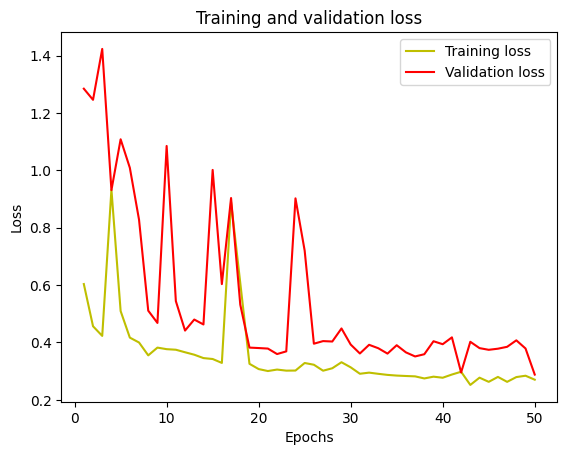

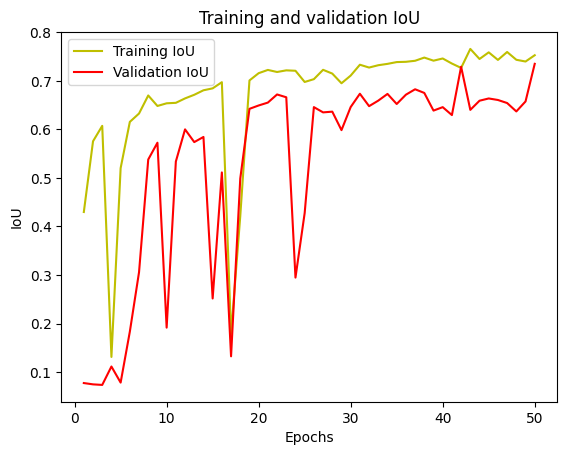

In [126]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["custom_iou_score"]
val_acc = history.history["val_custom_iou_score"]

plt.plot(epochs, acc, "y", label="Training IoU")
plt.plot(epochs, val_acc, "r", label="Validation IoU")
plt.title("Training and validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

In [127]:
print(model.input_shape, model.output_shape)


(None, 256, 256, 3) (None, 256, 256, 5)


### Evaulate model on test data

In [128]:

model = load_model(file_model, compile=False)
model.save(file_model)
# Test generator using validation data.
test_image_batch, test_mask_batch = val_img_gen.__next__()

# Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Mean IoU = 0.78340787


## Calculation

- Accuracy is typically used for classification tasks, where the goal is to predict discrete classes. In semantic segmentation, accuracy measures the percentage of pixels that are correctly classified.

- R-squared (R2) is commonly used in regression problems to measure the goodness of fit. It's less relevant in semantic segmentation, which is primarily a classification task.
- Mean Squared Error (MSE) is a regression metric that quantifies the average squared difference between predicted and true values. In semantic segmentation, it can be applied to the pixel-wise probabilities or class labels. However, it might not be the most informative metric for this task.
- Loss is the function used to optimize the model during training. In semantic segmentation, various loss functions can be employed, such as categorical cross-entropy or Dice loss. The loss value reflects the model's overall performance during training.

In [129]:
# Access the loss value from the training history
loss = history.history['loss'][-1]  # Get the last loss value
print("Loss:", loss)

from sklearn.metrics import mean_squared_error

# Flatten predictions and ground truth
y_true_flat = test_mask_batch_argmax.flatten()  # Or use original probabilities
y_pred_flat = test_pred_batch_argmax.flatten()  # Or use original probabilities

# Calculate MSE
mse = mean_squared_error(y_true_flat, y_pred_flat)
print("Mean Squared Error:", mse)


from sklearn.metrics import accuracy_score

# Flatten predictions and ground truth
y_true_flat = test_mask_batch_argmax.flatten()
y_pred_flat = test_pred_batch_argmax.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print("Accuracy:", accuracy)


# less Relevant
from sklearn.metrics import r2_score

# Assuming you have continuous predictions (e.g., probabilities)
y_true_flat = test_mask_batch.flatten()  # Use original probabilities
y_pred_flat = test_pred_batch.flatten()  # Use original probabilities

# Calculate R-squared
r2 = r2_score(y_true_flat, y_pred_flat)
print("R-squared:", r2)

Loss: 0.2701984643936157
Mean Squared Error: 0.4881995064871652
Accuracy: 0.9189442225864956
R-squared: 0.817423056349625


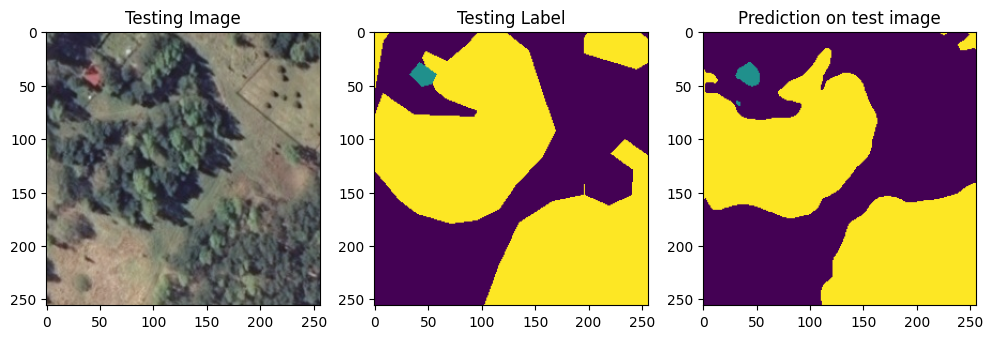

In [138]:
# View a few images, masks and corresponding predictions.
img_num = random.randint(0, test_image_batch.shape[0] - 1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title("Testing Image")
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title("Testing Label")
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title("Prediction on test image")
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()